In [2]:
import time

import numpy as np
import tensorflow as tf

import utils

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

PREPROCESSING

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
#int_words[:30]

SUBSAMPLING

In [6]:
from collections import Counter
import random
import math

treshold = 1e-5
ttreshold = 0.8
frequencies = {}
probabilities = {}
train_words = []

word_counts = Counter(int_words)

for word in word_counts:
    frequencies[word] = word_counts[word] / len(int_words)
    probabilities[word] = 1 - math.sqrt(treshold / frequencies[word])
#print(probabilities)
for word in int_words:
    if random.random() < probabilities[word]:
        train_words.append(word)
print(len(train_words))

12052691


MAKING BATCHES

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    r = random.randint(1, window_size + 1)
    start = idx - r if (idx - r) > 0 else 0
    stop = idx + r
    target_words = set(words[start:idx] + words[idx + 1:stop + 1])
    
    return list(target_words)
    
   
print(get_target(int_words, 10, 5))
print(int_words[:15]) 
    



[741, 10571, 45, 58, 155, 476]
[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133]


In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

TRAINING THE GRAPH

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

EMBEDDING

In [10]:
n_vocab = len(int_to_vocab)
n_embedding =  200
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1)) # create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer output

NEGATIVE SAMPLING

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal([n_vocab, n_embedding], stddev=0.1))# create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros(n_vocab)) # create softmax biases here
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
        
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

VALIDATION

In [12]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    
    valid_size = 16               # Random set of words to evaluate similarity on.
    valid_window = 100
    
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [13]:
!mkdir checkpoints

Џ®¤Ї ЇЄ  Ё«Ё д ©« checkpoints г¦Ґ бгйҐбвўгҐв.


TRAINING

In [14]:
#ПОСТАРАЮСЬ ДАТЬ ДОРАБОТАТЬ ДО КОНЦА
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 8.7307 0.6114 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 7.4611 0.5463 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 6.2062 0.5450 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.4902 0.5408 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.1655 0.5584 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 4.8579 0.5643 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 4.6314 0.5422 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 4.5059 0.5376 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 4.5668 0.5439 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 4.5286 0.5402 sec/batch
Nearest to by: detrimental, net, leave, required, central, equivalent, art, british,
Nearest to not: from, friend, begum, heart, particularly, ripper, out, has,
Nearest to if: most, failed, widespread, amalgam, he, longbows, vehicles, according,
Nearest to about: original, seats, types, during, ped

In [15]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


VISUALIZING THE WORD VECTORS

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [17]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

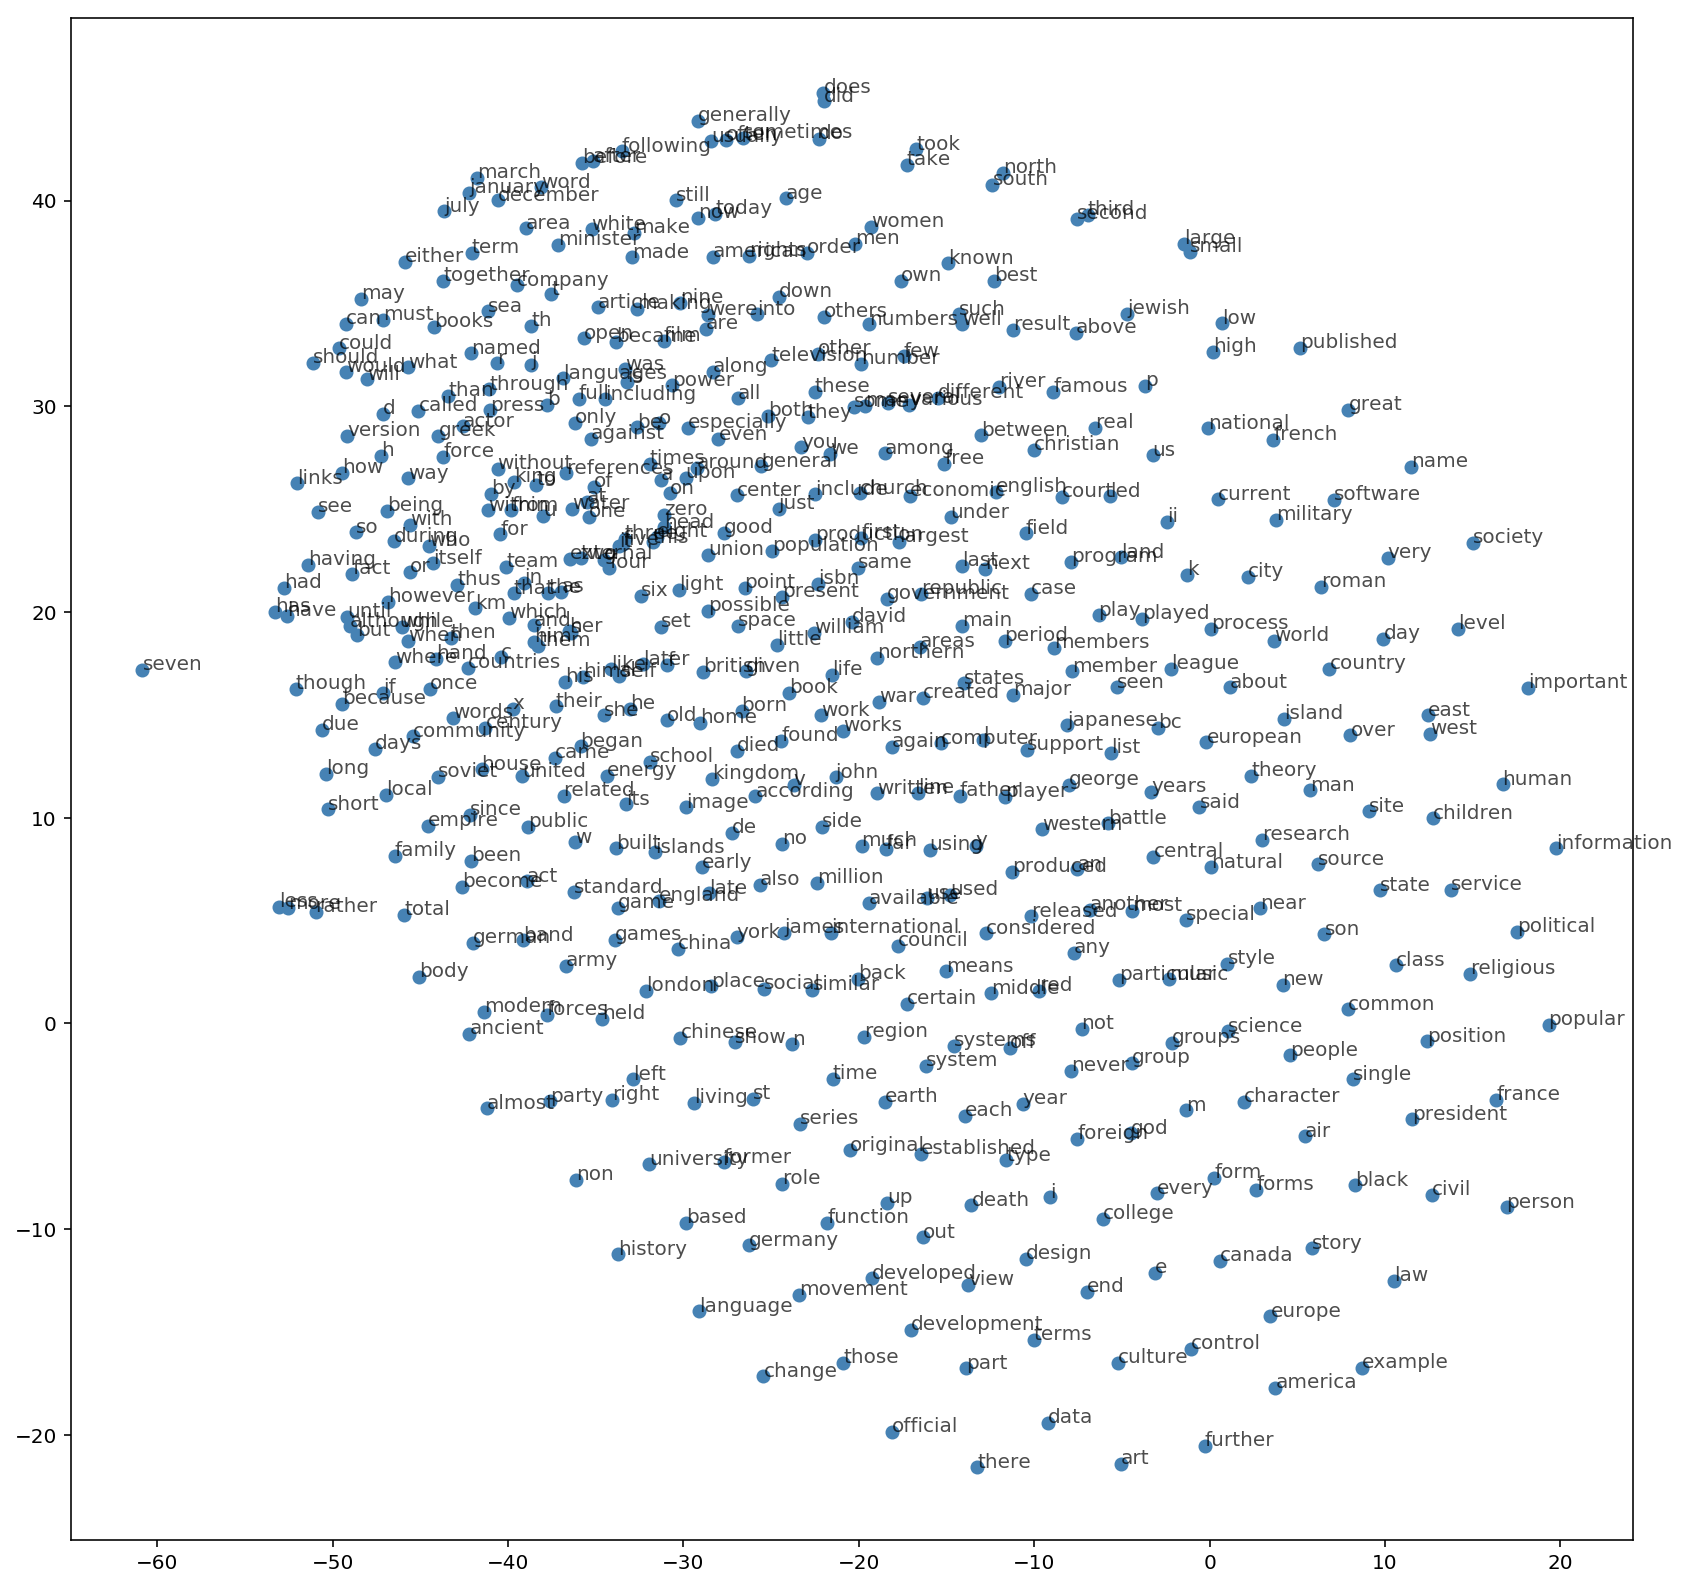

In [18]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)